In [1]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt 

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.transforms.aumentation import  ObjectImageMetadataTransform
from pytvision.transforms import transforms as mtrans

sys.path.append('../')
import torch.nn.functional as TF
from torchlib.transforms import functional as F
from torchlib.datasets.fersynthetic  import SyntheticFaceDataset
from torchlib.datasets.factory  import FactoryDataset
from torchlib.datasets.datasets import Dataset
from torchlib.datasets.fersynthetic  import SyntheticFaceDataset

from torchlib.attentionnet import AttentionNeuralNet
from aug import get_transforms_aug, get_transforms_det


## CONFIGURATE

In [2]:
!ls ../out/

exp_cb.mkv
exp_mz_sn.avi
exp_mz_sn.mkv
fer_atentionresnet34_attgmm_adam_bu3dfe_dim64_preactresnet18x32_fold01_000
fer_atentionresnet34_attgmm_adam_ferblack_dim64_preactresnet18x32_fold0_000
fer_atentionresnet34_attgmm_adam_ferblack_dim64_preactresnet18x32_fold0_001
fer_atentionresnet34_attgmm_adam_ferblack_dim64_preactresnet18x32_fold01_000
result


In [3]:
project          = '../out'
name             = 'fer_atentionresnet34_attgmm_adam_ferblack_dim64_preactresnet18x32_fold0_001'
pathnamedataset  = '~/.datasets'
pathmodel        = os.path.join( project, name, 'models/model_best.pth.tar' ) #model_best
pathproject      = os.path.join( project, name )
batch_size       = 2
workers          = 1
cuda             = False
parallel         = False
gpu              = 1
seed             = 1
imsize           = 128


## DATASET

In [9]:
# Load dataset
print('>> Load dataset ...')
namedataset = FactoryDataset.ferp
subset = FactoryDataset.training
imagesize=128

dataset = Dataset(    
    data=FactoryDataset.factory(
        pathname=pathnamedataset, 
        name=namedataset, 
        subset=subset, 
        #transform=train_transform, 
        download=True 
    ),
    num_channels=3,
    transform=transforms.Compose([
            #mtrans.ToPad(h_pad=10,w_pad=10),
            mtrans.ToResize( (imagesize, imagesize), resize_mode='square' ),
            #mtrans.ToRandomTransform(mtrans.ToGaussianNoise( sigma=0.1 ), prob=1.0 ),  
            #mtrans.RandomCrop( (255,255), limit=50, padding_mode=cv2.BORDER_CONSTANT  ),
            #mtrans.ToResizeUNetFoV(imsize, cv2.BORDER_REFLECT_101),
            mtrans.ToTensor(),
            mtrans.ToMeanNormalization( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
            #mtrans.ToNormalization(),
            ])
    )


# dataset = SyntheticFaceDataset(
#     data=FactoryDataset.factory(
#         pathname=pathnamedataset, 
#         name=namedataset, 
#         subset=subset, 
#         download=True 
#         ),
#     pathnameback='~/.datasets/coco', 
#     ext='jpg',
#     count=2000,
#     num_channels=3,
#     iluminate=True, angle=45, translation=0.3, warp=0.2, factor=0.2,
#     #iluminate=True, angle=45, translation=0.1, warp=0.0, factor=0.0,
#     transform_data=get_transforms_det( imsize ),
#     transform_image=get_transforms_det( imsize ),
#     )


print(len(dataset))
# print( dataset.classes )
# print( dataset.data.class_to_idx )


>> Load dataset ...
25045


## LOAD MODEL

In [6]:
# load model
print('>> Load model ...')

net = AttentionNeuralNet( 
    patchproject=project, 
    nameproject=name, 
    no_cuda=cuda, 
    parallel=parallel, 
    seed=seed, 
    gpu=gpu 
    )

if net.load( pathmodel ) is not True:
    assert(False)

Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


>> Load model ...
=> loading checkpoint '../out/fer_atentionresnet34_attgmm_adam_ferblack_dim64_preactresnet18x32_fold0_001/models/model_best.pth.tar'
=> loaded checkpoint for atentionresnet34 arch!


## TTA

torch.Size([1, 3, 128, 128])


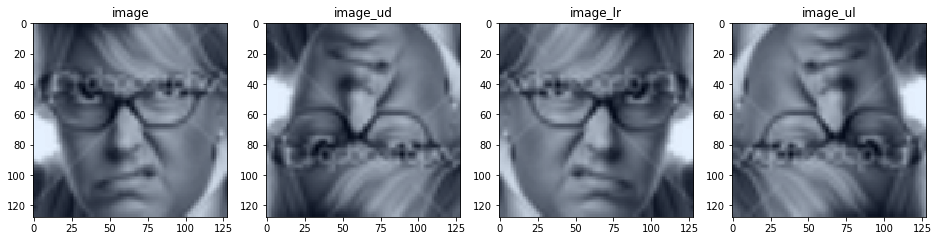

In [6]:
def norm(x):
    x = x-x.min()
    x = x / x.max()
    return x

sample   = dataset[ 0 ]
image    = sample['image'].unsqueeze(0)
print(image.shape)

image_ud = F.flipud( image )
image_lr = F.fliplr( image )
image_ul = F.flipud( F.fliplr( image ) )

image    = image.data.cpu().numpy().transpose(2,3,1,0)[...,0]
image_ud = image_ud.data.cpu().numpy().transpose(2,3,1,0)[...,0]
image_lr = image_lr.data.cpu().numpy().transpose(2,3,1,0)[...,0]
image_ul = image_ul.data.cpu().numpy().transpose(2,3,1,0)[...,0]


plt.figure( figsize=(16,8))
plt.subplot(141)
plt.imshow( norm(image) )
plt.title('image')
plt.subplot(142)
plt.imshow( norm(image_ud) )
plt.title('image_ud')
plt.subplot(143)
plt.imshow( norm(image_lr) )
plt.title('image_lr')
plt.subplot(144)
plt.imshow( norm(image_ul) )
plt.title('image_ul')
plt.show()


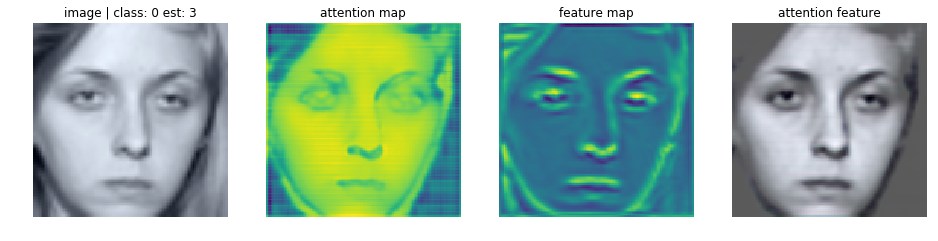

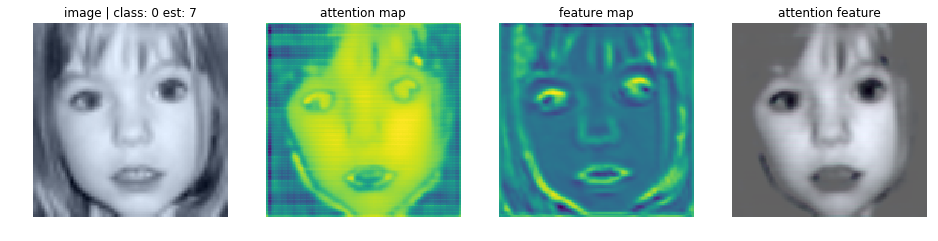

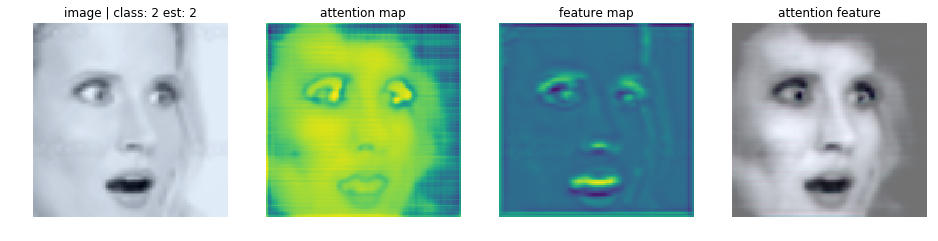

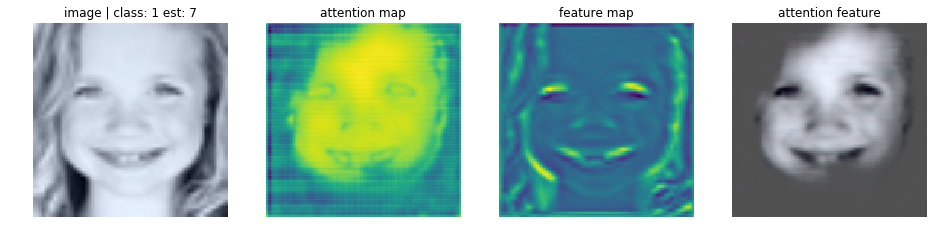

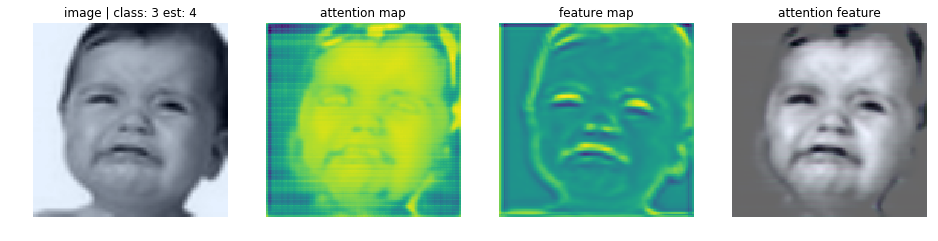

In [14]:
def norm(x):
    x = x-x.min()
    x = x / x.max()
    return x

idx=0
k=0
for i in range( len(dataset) ):
    
    idx = i + 50
    sample = dataset[ idx ]    
    
    #image_org, image, mask, label = sample
    #image = image.unsqueeze(0)
    
    image = sample['image'].unsqueeze(0)
    label = sample['label'].argmax()
    #image = F.fliplr( image )
    
    z, y_lab_hat, att, fmap, srf = net( image )    
    
    att  = att.data.cpu().numpy().transpose(2,3,1,0)[...,0]
    fmap = fmap.data.cpu().numpy().transpose(2,3,1,0)[:,:,0,0]
    srf  = srf.data.cpu().numpy().transpose(2,3,1,0)[...,0]
    image = image.data.cpu().numpy().transpose(2,3,1,0)[...,0]
    y_lab_hat_max = y_lab_hat.argmax()
    
    
    #if label != 6: continue    
    k+=1    
    if k > 5: break

    plt.figure( figsize=(16,8))
    plt.subplot(141)
    plt.imshow( norm(image) )
    plt.title('image | class: {} est: {}'.format( label, y_lab_hat_max ) )    
    plt.axis('off')
    plt.subplot(142)
    plt.imshow( (fmap))
    plt.title('attention map') 
    plt.axis('off' )
    plt.subplot(143)
    plt.imshow( srf.sum(2) )
    plt.title('feature map') 
    plt.axis('off' )
    plt.subplot(144)
    plt.imshow( norm(att) )  
    plt.title('attention feature') 
    plt.axis('off')
    
    plt.show()



tensor(0, device='cuda:1') | tensor(0)


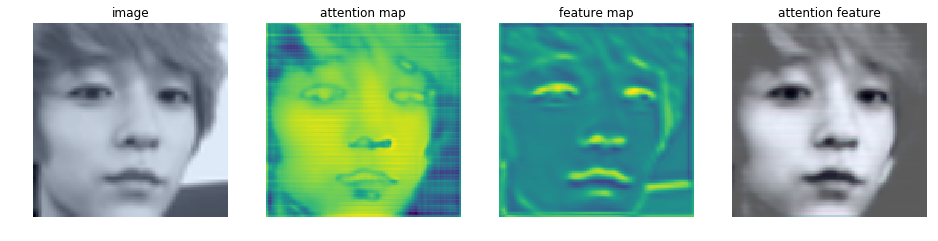

In [16]:
def norm(x):
    x = x-x.min()
    x = x / x.max()
    return x

def sigmoid(x):
    return 1. / (1 + np.exp(-x))

def save(image, srf, fmap, att, pathname='../netruns/', pos_name=''):
    image_name = os.path.join(pathname, '{}_{}.png'.format('image', pos_name) )
    srf_name   = os.path.join(pathname, '{}_{}.png'.format('srf', pos_name) )
    map_name   = os.path.join(pathname, '{}_{}.png'.format('map', pos_name) )
    smap_name  = os.path.join(pathname, '{}_{}.png'.format('sigma_map', pos_name) )
    att_name   = os.path.join(pathname, '{}_{}.png'.format('att', pos_name) )  
    fig = plt.figure(figsize=(8,8)); plt.imshow( norm(image) ); plt.axis('off' ); fig.savefig(image_name, bbox_inches='tight',transparent=True, pad_inches=0) 
    fig = plt.figure(figsize=(8,8)); plt.imshow( srf.sum(2)  ); plt.axis('off' ); fig.savefig(srf_name, bbox_inches='tight',transparent=True, pad_inches=0)
    fig = plt.figure(figsize=(8,8)); plt.imshow( (fmap)  ); plt.axis('off' ); fig.savefig(map_name, bbox_inches='tight',transparent=True, pad_inches=0)
    fig = plt.figure(figsize=(8,8)); plt.imshow( sigmoid(fmap)  ); plt.axis('off' ); fig.savefig(smap_name, bbox_inches='tight',transparent=True, pad_inches=0)
    fig = plt.figure(figsize=(8,8)); plt.imshow( norm(att)  ); plt.axis('off' ); fig.savefig(att_name, bbox_inches='tight',transparent=True, pad_inches=0)
    


idx=10
sample = dataset[ idx ]    

#image, mask, label = sample
#image = image.unsqueeze(0)

image = sample['image'].unsqueeze(0)
label = sample['label'].argmax()

z, y_lab_hat, att, fmap, srf = net( image ) 

att  = att.data.cpu().numpy().transpose(2,3,1,0)[...,0]
fmap = fmap.data.cpu().numpy().transpose(2,3,1,0)[:,:,0,0]
srf  = srf.data.cpu().numpy().transpose(2,3,1,0)[...,0]
image = image.data.cpu().numpy().transpose(2,3,1,0)[...,0]
y_lab_hat = y_lab_hat.argmax()
print(y_lab_hat,'|',label)


# save( norm(image), srf, fmap, att  )

plt.figure( figsize=(16,8))
plt.subplot(141)
plt.imshow( norm(image) )
plt.title('image')   
plt.axis('off')
plt.subplot(142)
plt.imshow( (fmap) ) #sigmoid
plt.title('attention map') 
plt.axis('off' )
plt.subplot(143)
plt.imshow( srf.sum(2) )
plt.title('feature map') 
plt.axis('off' )
plt.subplot(144)
plt.imshow( norm(att) )  
# plt.title('class {}/{}'.format(y_lab_hat, label) ) 
plt.title('attention feature') 
plt.axis('off')

plt.show()


torch.Size([1, 3, 128, 128])
(128, 128) -14.379339 0.9062203
(128, 128, 32) -12.115273 11.66557
tensor(1, device='cuda:1') Happiness - HA
(128, 128, 3) 0.0 1.0


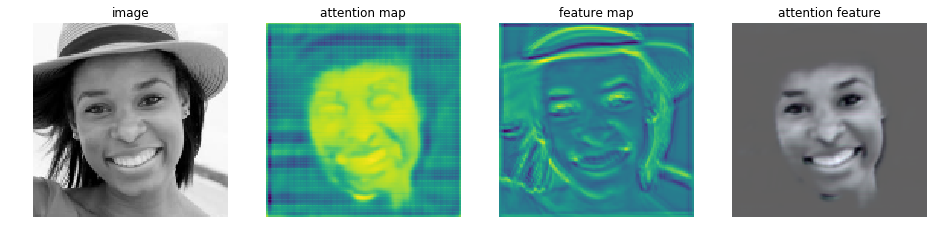

In [17]:
import random
import scipy.misc


def sigmoid(x):
    return 1. / (1 + np.exp(-x))

def norm(x):
    x = x-x.min()
    x = x / x.max()
    return x

def mean_normalization(image, mean, std):
    tensor = image.float()/255.0
    result_tensor = []
    for t, m, s in zip(tensor, mean, std):  
        result_tensor.append(t.sub_(m).div_(s))            
    return torch.stack(result_tensor, 0)

def pad(image, xypad):
    h,w = image.shape
    im_pad = np.zeros( (h+2*xypad,w+2*xypad) )
    im_pad[xypad:xypad+h,xypad:xypad+w] = image
    return im_pad
    
def crop(image, xycrop):
    h,w = image.shape[:2]
    image = image[ xycrop:h-xycrop,xycrop:w-xycrop]
    return image 
    
    
imagesize=128
image = cv2.imread('../rec/selfie_happy.png')[:,:,(2,1,0)].mean(axis=2)

# sigma=0.001
# image = image/255.0
# noise = np.array([random.gauss(0,sigma) for i in range( image.shape[0]*image.shape[1]  )])
# noise = noise.reshape(image.shape[0],image.shape[1])
# image = (np.clip(image+noise,0,1)*255).astype(np.uint8)

# # image = pad(image,10)
image = crop(image, 50)

image = np.stack( (image,image,image), axis=2 )
image = cv2.resize( image, (imagesize,imagesize) )
# image = norm((image/255)**1.0)*255

image = torch.from_numpy(image).permute( (2,0,1) ).unsqueeze(0).float()
image = mean_normalization(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
print(image.shape)

z, y_lab_hat, att, fmap, srf = net( image )

att  = att.data.cpu().numpy().transpose(2,3,1,0)[...,0]
fmap = fmap.data.cpu().numpy().transpose(2,3,1,0)[:,:,0,0]
srf  = srf.data.cpu().numpy().transpose(2,3,1,0)[...,0]
image = image.data.cpu().numpy().transpose(2,3,1,0)[...,0]
y_lab_hat = y_lab_hat.argmax()


print(fmap.shape, fmap.min(), fmap.max() )
print(srf.shape, srf.min(), srf.max() )
print(y_lab_hat, dataset.data.classes[y_lab_hat])

att_mask = (np.abs( att ) > 0.2).astype(np.float)
print(att_mask.shape, att_mask.min(), att_mask.max() )

image = norm(image)
#print(image.min(), image.max() )


plt.figure( figsize=(16,8))
plt.subplot(141)
plt.imshow( image )
plt.title('image')   
plt.axis('off')
plt.subplot(142)
plt.imshow( (fmap))
plt.title('attention map') 
plt.axis('off' )
plt.subplot(143)
plt.imshow( srf.sum(2) )
plt.title('feature map') 
plt.axis('off' )
plt.subplot(144)
plt.imshow( norm(att) )  
# plt.title('class {}/{}'.format(y_lab_hat, label) ) 
plt.title('attention feature') 
plt.axis('off')

plt.show()

In [25]:
import os


def save(image, srf, fmap, att, imemotion, pathname='../netruns/results/', pos_name=''):
    image_name = os.path.join(pathname, '{}_{}.png'.format('image', pos_name) )
    srf_name   = os.path.join(pathname, '{}_{}.png'.format('srf', pos_name) )
    map_name   = os.path.join(pathname, '{}_{}.png'.format('map', pos_name) )
    smap_name  = os.path.join(pathname, '{}_{}.png'.format('sigma_map', pos_name) )
    att_name   = os.path.join(pathname, '{}_{}.png'.format('att', pos_name) )    
    emo_name   = os.path.join(pathname, '{}_{}.png'.format('emotion', pos_name) ) 
    
    fig = plt.figure(figsize=(8,8)); plt.imshow( norm(image) ); plt.axis('off' ); fig.savefig(image_name, bbox_inches='tight',transparent=True, pad_inches=0) 
    fig = plt.figure(figsize=(8,8)); plt.imshow( srf.sum(2)  ); plt.axis('off' ); fig.savefig(srf_name, bbox_inches='tight',transparent=True, pad_inches=0)
    fig = plt.figure(figsize=(8,8)); plt.imshow( (fmap)  ); plt.axis('off' ); fig.savefig(map_name, bbox_inches='tight',transparent=True, pad_inches=0)
    fig = plt.figure(figsize=(8,8)); plt.imshow( sigmoid(fmap)  ); plt.axis('off' ); fig.savefig(smap_name, bbox_inches='tight',transparent=True, pad_inches=0)
    fig = plt.figure(figsize=(8,8)); plt.imshow( norm(att)  ); plt.axis('off' ); fig.savefig(att_name, bbox_inches='tight',transparent=True, pad_inches=0)
    fig = plt.figure(figsize=(8,8)); plt.imshow( imemotion  ); plt.axis('off' ); fig.savefig(emo_name, bbox_inches='tight',transparent=True, pad_inches=0)
    
    

    
def drawlabel(y, emotions, imsize=(500,500,3)):
    
    colors = ([255,255,255],[255,255,255],[0,0,0],[0,0,0])
    hbox=32; wbox=135 + 210
    imemotions = np.ones( imsize, dtype=np.uint8 )*255     
    ymax = y.argmax()
    
    for i, yi in enumerate(y):

        k = 1 if y[i]>0.5 else 0
        kh = 1 if ymax==i else 0
    
        bbox = np.array([[0,0],[wbox,0],[wbox,hbox],[0,hbox]]);    
        bbox[:,0] += 19
        bbox[:,1] += 50-28 + (i)*40
        imemotions = cv2.fillConvexPoly(imemotions, bbox, color=colors[kh] )
        
        bbox = np.array([[0,0],[int(wbox*y[i]),0],[int(y[i]*wbox),hbox],[0,hbox]]);    
        bbox[:,0] += 19
        bbox[:,1] += 50-28 + (i)*40
        imemotions = cv2.fillConvexPoly(imemotions, bbox, color=[255,160,122] )
        
        cv2.putText(
                imemotions, 
                '{}: {:.3f}'.format(emotions[i][:-5],y[i]), 
                (20, 50 + (i)*40), 
                color=colors[2+kh], 
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
                fontScale=1, 
                thickness=2
                )
        
    imemotions = imemotions[20:-20,20:-20,:]
    #imemotions = cv2.resize( imemotions, (128,128) )
    return imemotions
    

imagesize=128

# sigmas = [ 0.01, 0.05, 0.07, 0.09, 0.1, 0.2, 0.3, 0.4 ]
sigmas = [ 0.03 ]
for i,sigma in enumerate(sigmas):

# gammas = [0.1, 0.2, 0.5, 1.0, 1.2, 1.5, 1.8, 2.0]
# gammas = [1.0]
# for i,gamma in enumerate(gammas):


    image = cv2.imread('../rec/selfie_happy.png')[:,:,(2,1,0)].mean(axis=2)
    image = crop(image, 50)
    
    image = image/255.0
    noise = np.array([random.gauss(0,sigma) for i in range( image.shape[0]*image.shape[1]  )])
    noise = noise.reshape(image.shape[0],image.shape[1])
    image = (np.clip(image+noise,0,1)*255).astype(np.uint8)
    
    # image = pad(image,10)
    image = np.stack( (image,image,image), axis=2 )
    image = cv2.resize( image, (imagesize,imagesize) )
#     image = norm((image/255)**gamma)*255

    image = torch.from_numpy(image).permute( (2,0,1) ).unsqueeze(0).float()
    image = mean_normalization(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #print(image.shape)

    z, y_lab_hat, att, fmap, srf = net( image )

    att  = att.data.cpu().numpy().transpose(2,3,1,0)[...,0]
    fmap = fmap.data.cpu().numpy().transpose(2,3,1,0)[:,:,0,0]
    srf  = srf.data.cpu().numpy().transpose(2,3,1,0)[...,0]
    image = image.data.cpu().numpy().transpose(2,3,1,0)[...,0]
    y_lab_hat_max = y_lab_hat.argmax()
        
    y_lab_hat = TF.softmax( y_lab_hat, dim=1 )
    #print(y_lab_hat)
    #print(y_lab_hat.shape)

    #print(fmap.shape, fmap.min(), fmap.max() )
    #print(srf.shape, srf.min(), srf.max() )
    #print(y_lab_hat_max, dataset.data.classes[y_lab_hat_max])
    
    emotions = dataset.data.classes
    imemotion = drawlabel(y_lab_hat[0,:], emotions, imsize=(360,385,3) )
            
       
#     save( image, srf, fmap, att, imemotion,   pathname='../netruns/results/', pos_name=i  )
    
    print('save ...')



save ...


In [19]:

dataloader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=40 )
#print( len(dataset) )


Y_labs = []
Y_lab_hats = []
Zs = [] 
for i_batch, sample in enumerate( tqdm(dataloader) ):
    #print(sample['image'].shape, sample['label'].shape)
    
    x_img, y_lab = sample['image'], sample['label']
#     x_org, x_img, y_mask, y_lab = sample
    
    x_img = x_img.cuda()
    y_lab = y_lab.argmax(dim=1)
    z, y_lab_hat, att, _,_ = net( x_img )
    
    Y_labs.append(y_lab)
    Y_lab_hats.append(y_lab_hat.data.cpu())
    Zs.append(z.data.cpu())
    
    
Y_labs = np.concatenate( Y_labs, axis=0 )
Y_lab_hats = np.concatenate( Y_lab_hats, axis=0 )
Zs = np.concatenate( Zs, axis=0 )

print(Y_lab_hats.shape, Zs.shape, Y_labs.shape)

reppathname = os.path.join( pathproject, 'rep_{}_{}_{}.pth'.format(name, namedataset, subset) )
torch.save( { 'Yh':Y_lab_hats, 'Z':Zs, 'Y':Y_labs }, reppathname )

print('>>> save')

100%|██████████| 251/251 [00:51<00:00,  4.87it/s]


(25045, 8) (25045, 1000) (25045,)
>>> save


In [20]:
from sklearn.manifold import TSNE

reppathname = os.path.join( pathproject, 'rep_{}_{}_{}.pth'.format(name, namedataset, subset) )
tsnpathname = os.path.join( pathproject, 'tsn_{}_{}_{}.csv'.format(name, namedataset, subset ) )

rep_data = torch.load(reppathname)
Z = rep_data['Z']
Y = rep_data['Y']

Z = Z[:2000,:]
Y = Y[:2000] #,0

print('load data')
print('Z:', Z.shape)
print('Y:', Y.shape)

#data_emb = pd.read_csv( reppathname )
#data_emb = data_emb.as_matrix()
#Xo = data_emb[:,:-1]
#Yo = data_emb[:,-1]

Zt = TSNE(n_components=2, init='pca', 
    random_state=0, perplexity=30).fit_transform(Z)


# save
ZY = np.concatenate((Zt,Y[:, np.newaxis]),axis=1)
df = pd.DataFrame( ZY )
df.to_csv( tsnpathname , index=False, encoding='utf-8')

print('tsne calculte done')

load data
Z: (2000, 1000)
Y: (2000,)
tsne calculte done


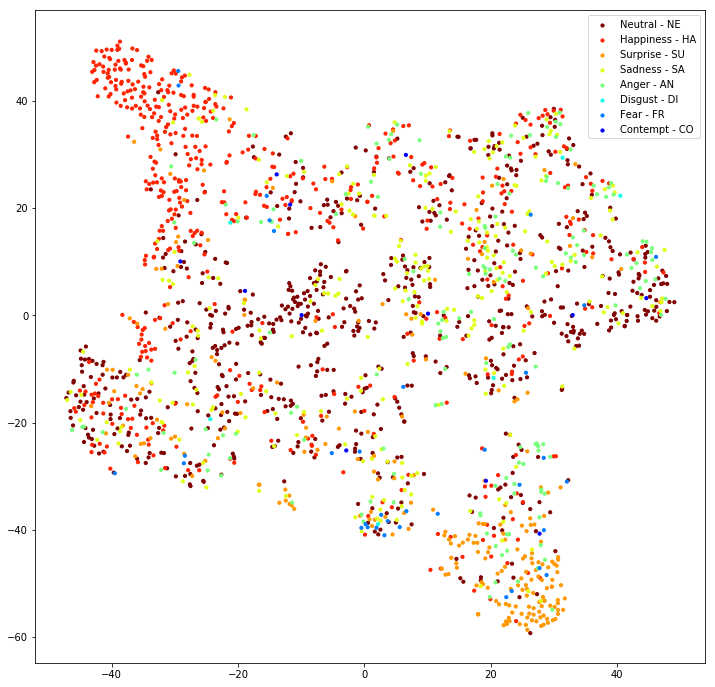

In [21]:
cmap = plt.get_cmap('jet_r')

#show
plt.figure( figsize=(12,12) )
#plt.scatter(Xt[:,0], Xt[:,1], s=(10,10), marker='o', c=Yo);
n = len(np.unique(Y))
for i in range( n ):
    index = Y==i
    color = cmap(float(i)/n) 
    plt.scatter(Zt[index,0], Zt[index,1], s=(10,10), marker='o', color=color, label='{}'.format( dataloader.dataset.data.classes[i] ) );

plt.legend()
plt.savefig( os.path.join( pathproject, 'tsn_{}_{}_{}.png'.format( name, namedataset, subset ) ) )
plt.show()


In [22]:
import sklearn.metrics as metrics

rep_val_pathname = os.path.join( pathproject, 'rep_{}_{}_{}.pth'.format(name, namedataset, 'train') )
# rep_val_pathname = os.path.join( pathproject, 'rep_{}_{}_{}.pth'.format(name, namedataset, 'val') )
# rep_val_pathname = os.path.join( pathproject, 'rep_{}_{}_{}.pth'.format(name, namedataset, 'test') )
data_emb_val = torch.load(rep_val_pathname)

Xto = data_emb_val['Z']
Yto = data_emb_val['Y']
Yho = data_emb_val['Yh']

yhat = np.argmax( Yho, axis=1 )
y    = Yto

acc = metrics.accuracy_score(y, yhat)
precision = metrics.precision_score(y, yhat, average='macro')
recall = metrics.recall_score(y, yhat, average='macro')
f1_score = 2*precision*recall/(precision+recall)

print('Accuracy : %f' % acc)
print('Precision : %f' % precision)
print('Recall : %f' % recall)
print('F1 score : %f' % f1_score)
print("")


Accuracy : 0.290717
Precision : 0.335302
Recall : 0.319123
F1 score : 0.327013



580


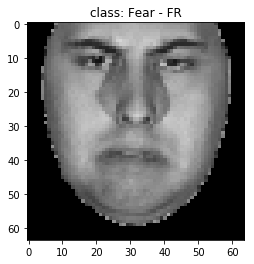

In [31]:
size_input=64
data = Dataset(
    data=FactoryDataset.factory(
        pathname=pathnamedataset, 
        name=namedataset, 
        subset=subset, 
        download=False ),
    num_channels=3,
    transform=mtrans.ToResize( (size_input, size_input), resize_mode='square', padding_mode=cv2.BORDER_CONSTANT ) 
    )

n = len(data)
#img, label = data[ np.random.randint(n) ]
sample = data[ np.random.randint(n) ]
img, label = sample['image'], sample['label']
label=np.argmax(label)
classe = data.data.classes[label]

#print(img)
#img = np.array(img)
#print(img.shape, np.max(img) )

print(n)
plt.figure( figsize=(4,4))
plt.imshow( img )
plt.title('class: {}'.format(classe) )
plt.show()

In [13]:
import scipy.misc
import cv2

def drawmanifold( images, x, y, S=2000, s=50, Ntake = 100, freq_print=100, bgblack=True ):
    '''
    drawmanifold
    S = 2000 # size of full embedding image
    s = 50 # size of every single image   
    Ntake = 200 #count of the object
    
    #Example    
    Mf = drawmanifold(data, Xt)
    plt.figure( figsize=(12,12) )
    plt.imshow(Mf)
    plt.show()
    
    '''
    
    #normalization 
    x = x - np.min(x)
    x = x / np.max(x)
    
    n = len(np.unique(y))
    cmap = plt.get_cmap('jet_r')        
    if bgblack: G = np.zeros( (S, S, 3), dtype='uint8')
    else: G = np.ones( (S, S, 3), dtype='uint8')*255
    
    
    for i in range(Ntake):

        if (i-1)%freq_print == 0:
            print('{}/{}...\n'.format(i, Ntake)  )

        # location
        a = np.ceil(x[i, 0] * (S-s))
        b = np.ceil(x[i, 1] * (S-s))
        
        a = int(a - (a)%s) 
        b = int(b - (b)%s) 

        #if G[a,b,1] != 0:
        #    continue # spot already filled
        
        I = images[i]['image']; 
        
        imshape = I.shape;
        Imask = np.ones((imshape[0]+11,imshape[1]+11))
        
        color = cmap(float(y[i])/n)
        #color = colors[ int(y[i]) ]
        
        Ir = Imask*color[0]*255
        Ig = Imask*color[1]*255
        Ib = Imask*color[2]*255
                
        Ir[5:-6,5:-6] = I[:,:,0]
        Ig[5:-6,5:-6] = I[:,:,1]
        Ib[5:-6,5:-6] = I[:,:,2]
        
        Ir = Ir[:,:, np.newaxis ]; 
        Ig = Ig[:,:, np.newaxis ]; 
        Ib = Ib[:,:, np.newaxis ]; 
        Irgb = np.concatenate((Ir,Ig,Ib), axis=2 )         
        
        Irgb = scipy.misc.imresize(Irgb, (s,s), interp='bilinear' ) 
        cv2.putText(Irgb, 'c{}'.format( int(y[i]) ) ,(10,s-10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,0,0), 1, cv2.LINE_AA)
        
        G[a:a+s, b:b+s, :] = Irgb;
        
                
#         if len(I.shape)==2: I = I[:,:, np.newaxis ]
#         if I.shape[2] == 1: I = np.concatenate((I,I,I), axis=2 )   
#         I = scipy.misc.imresize(I, (s,s), interp='bilinear' )           
#         G[a:a+s, b:b+s, :] = I;
                      
    return G

1/580...



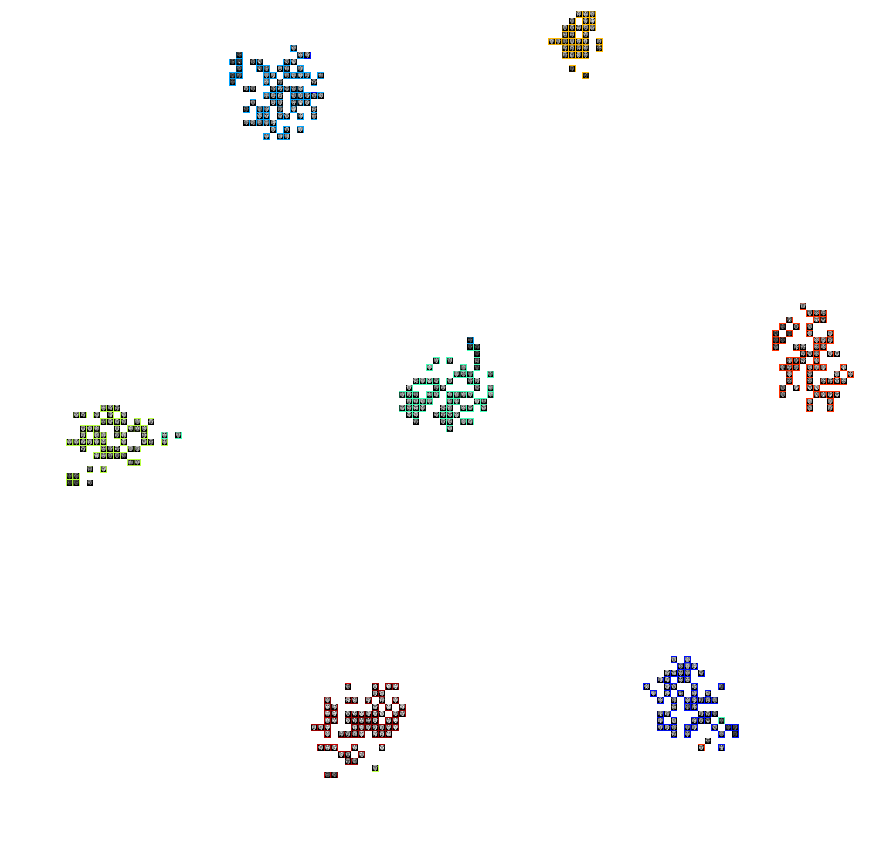

In [14]:

tsnpathname = os.path.join( pathproject, 'tsn_{}_{}_{}.csv'.format( name, namedataset, subset ) )
tsndata = pd.read_csv( tsnpathname )
tsnXY = tsndata.as_matrix()         
Xt = tsnXY[:,:-1]
Yt = tsnXY[:,-1]

Mf = drawmanifold(data, Xt, Yt, Ntake=len(data) , S=6000, s=50, freq_print=3000, bgblack=False ) #len(data)
scipy.misc.imsave( os.path.join( pathproject, 'tsn_img_{}_{}_{}.jpg'.format( name, namedataset, subset ) )   , Mf)

plt.figure( figsize=(12,12) )
plt.imshow(Mf)
plt.axis('off')
plt.tight_layout()
plt.ioff()
plt.show()



In [20]:
# http://scikit-learn.org/stable/modules/multiclass.html#multiclass
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as metrics


rep_trn_pathname = os.path.join( pathproject, 'rep_{}_{}_{}.pth'.format(name, namedataset, 'train') )
rep_val_pathname = os.path.join( pathproject, 'rep_{}_{}_{}.pth'.format(name, namedataset, 'val') )
#rep_val_pathname = os.path.join( pathproject, 'rep_{}_{}_{}.pth'.format(name, namedataset, 'test') )


data_emb_train = torch.load(rep_trn_pathname)
data_emb_val = torch.load(rep_val_pathname)
# data_emb_test = torch.load(rep_test_pathname)

Xo  = data_emb_train['Z']
Yo  = data_emb_train['Y'][:,0]
Xto = data_emb_val['Z']
Yto = data_emb_val['Y'][:,0]



clf = KNeighborsClassifier(n_neighbors=11)
# clf = GaussianNB()
# clf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
# clf = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=100, alpha=1e-4,
#                     solver='sgd', verbose=10, tol=1e-4, random_state=1,
#                     learning_rate_init=.01)

clf.fit(Xo,Yo)

# Xto = Xtest[:,:-1]
# Yto = Xtest[:,-1]
# Xto = Xval[:,:-1]
# Yto = Xval[:,-1]

y = Yto
yhat = clf.predict(Xto)


acc = metrics.accuracy_score(y, yhat)
nmi_s = metrics.cluster.normalized_mutual_info_score(y, yhat)
mi = metrics.cluster.mutual_info_score(y, yhat)
h1 = metrics.cluster.entropy(y)
h2 = metrics.cluster.entropy(yhat)
nmi = 2*mi/(h1+h2)

print(mi, h1, h2)
    
precision = metrics.precision_score(y, yhat, average='macro')
recall = metrics.recall_score(y, yhat, average='macro')
f1_score = 2*precision*recall/(precision+recall)

print('Accuracy : %f' % acc)
print('NMI : %f vs old %f' % (nmi, nmi_s))
print('Precision : %f' % precision)
print('Recall : %f' % recall)
print('F1 score : %f' % f1_score)
print("")



1.015924507558982 1.932352134341058 1.8981634538875922
Accuracy : 0.712500
NMI : 0.530437 vs old 0.530459
Precision : 0.746053
Recall : 0.725953
F1 score : 0.735866



In [236]:
import sklearn.metrics as metrics


namedataset = FactoryDataset.ferblack
subset = FactoryDataset.validation
imagesize=128


def get_transforms_noise(size_input, sigma):    
    return transforms.Compose([
        mtrans.ToResize( (size_input, size_input), resize_mode='squash' ) ,
        mtrans.ToGaussianNoise( sigma=sigma ), 
        mtrans.ToTensor(),
         mtrans.ToMeanNormalization( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] ),
        ])


accs = []
sigmas = [ 0.01, 0.05, 0.07, 0.09, 0.1, 0.2, 0.3, 0.4 ]
# sigmas = [ 0.09 ]
for sigma in sigmas:


#     dataset = Dataset(    
#         data=FactoryDataset.factory(
#             pathname=pathnamedataset, 
#             name=namedataset, 
#             subset=subset, 
#             #transform=train_transform, 
#             download=True 
#         ),
#         num_channels=3,
#         transform=transforms.Compose([
#                 mtrans.ToResize( (imagesize, imagesize), resize_mode='square' ),
#                 mtrans.ToGaussianNoise( sigma=sigma ), 
#                 mtrans.ToTensor(),
#                 mtrans.ToMeanNormalization( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
#                 ])
#         )

    dataset = SyntheticFaceDataset(
        data=FactoryDataset.factory(
            pathname='~/.datasets/', 
            name=namedataset, 
            subset=subset, 
            download=True 
            ),
        pathnameback='~/.datasets/coco', 
        ext='jpg',
        count=2000,
        num_channels=3,
        iluminate=True, angle=45, translation=0.3, warp=0.2, factor=0.2,
        transform_data=get_transforms_noise( imsize, sigma ),
        transform_image=get_transforms_det( imsize ),
        )

    dataloader = DataLoader(dataset, batch_size=40, shuffle=False, num_workers=10 )

    Y_labs = []
    Y_lab_hats = []
    Zs = [] 
    for i_batch, sample in enumerate( tqdm(dataloader) ):   
        #x_img, y_lab = sample['image'], sample['label']
        x_org, x_img, y_mask, y_lab = sample
        x_img = x_img.cuda()
        #y_lab = y_lab.argmax(dim=1)
        z, y_lab_hat, att, _,_ = net( x_img )
        Y_labs.append(y_lab)
        Y_lab_hats.append(y_lab_hat.data.cpu())
        Zs.append(z.data.cpu())

    Y_labs = np.concatenate( Y_labs, axis=0 )
    Y_lab_hats = np.concatenate( Y_lab_hats, axis=0 )
    Zs = np.concatenate( Zs, axis=0 )

    Xto = Zs
    Yto = Y_labs
    Yho = Y_lab_hats

    yhat = np.argmax( Yho, axis=1 )
    y    = Yto

    acc = metrics.accuracy_score(y, yhat)
    precision = metrics.precision_score(y, yhat, average='macro')
    recall = metrics.recall_score(y, yhat, average='macro')
    f1_score = 2*precision*recall/(precision+recall)

    accs.append(acc)
    #print('Accuracy : %f' % acc)
    #print('Precision : %f' % precision)
    #print('Recall : %f' % recall)
    #print('F1 score : %f' % f1_score)
    #print("")
    
accs = np.stack( accs, axis=0 )
print(accs)


ValueError: need at least one array to stack

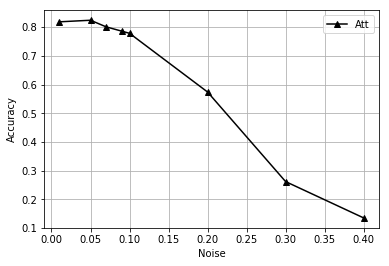

In [229]:
plt.figure()
plt.plot(sigmas, accs, '-k^', label='Att' )
#plt.plot(ix, accK*100, '-b^', label='Acc@K')
plt.xlabel('Noise')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Real

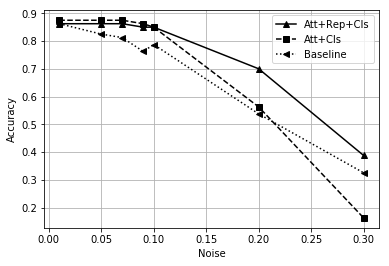

In [234]:

accs_base    = [0.8625, 0.825,  0.8125, 0.7625, 0.7875, 0.5375, 0.325,  0.2375]
accs_att_cls = [0.875,  0.875,  0.875,  0.8625, 0.85,   0.5625, 0.1625, 0.1625]
accs_att_rep = [0.8625, 0.8625, 0.8625, 0.85,   0.85,   0.7,    0.3875, 0.1375]

plt.figure()
plt.plot(sigmas[:-1], accs_att_rep[:-1], '-k^', label='Att+Rep+Cls' )
plt.plot(sigmas[:-1], accs_att_cls[:-1], '--ks', label='Att+Cls' )
plt.plot(sigmas[:-1], accs_base[:-1], ':k<', label='Baseline' )

plt.xlabel('Noise')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.savefig('../netruns/noise_realdataset.png')
plt.show()




In [ ]:
#Synthetic

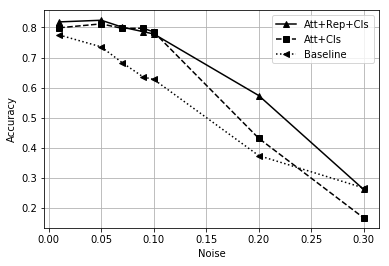

In [235]:

accs_base    = [0.775,  0.7355, 0.683,  0.6355, 0.6275, 0.3745, 0.267,  0.221 ]
accs_att_cls = [0.799,  0.812,  0.797,  0.7975, 0.785,  0.432,  0.1675, 0.1625]
accs_att_rep = [0.8185, 0.824,  0.801,  0.786,  0.7785, 0.574,  0.262,  0.1355]

plt.figure()
plt.plot(sigmas[:-1], accs_att_rep[:-1], '-k^', label='Att+Rep+Cls' )
plt.plot(sigmas[:-1], accs_att_cls[:-1], '--ks', label='Att+Cls' )
plt.plot(sigmas[:-1], accs_base[:-1], ':k<', label='Baseline' )

plt.xlabel('Noise')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.savefig('../out/noise_syntheticdataset.png')
plt.show()


